# PRM Algorithm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.patches import Circle
import numpy as np
from matplotlib import collections  as mc
import random
import pandas as pd

import tensorflow as tf
import keras as keras
from keras.layers import PReLU
from keras import layers, losses, models
from keras.models import Model

from sklearn.neural_network import MLPRegressor

import time
import pickle
from utilityPRM import *

In [2]:
print(tf.__version__)

2.12.0


# Laberinto

In [3]:
class Obstacle:
  pos = ''
  width = ''
  height = ''

  def __init__(self, p, w, h):
    self.pos = p
    self.width = w
    self.height = h

liminf_X = 0
limsup_X = 8
liminf_Y = 0
limsup_Y = 8


obstacles = []
wt = 0.25/2

#Paredes del laberinto
obstacles.append(Obstacle((2-wt,0), 0.25, 2 + wt))
obstacles.append(Obstacle((2+wt, 2-wt), 2, 0.25))

obstacles.append(Obstacle((0, 4-wt), 4-wt, 0.25))
obstacles.append(Obstacle((4-wt, 4-wt), 0.25, 2 + 2*wt))
obstacles.append(Obstacle((2-wt, 6-wt), 2, 0.25))

obstacles.append(Obstacle((6-wt, 6-wt), 0.25, 2 + 2*wt))

obstacles.append(Obstacle((6-wt, 2-wt), 0.25, 2 + 2*wt))
obstacles.append(Obstacle((6+wt, 4-wt), 2-wt, 0.25))

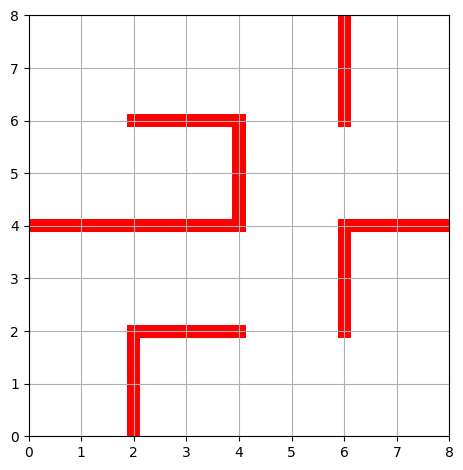

In [2]:
fig, ax = plt.subplots()
ax.set_xlim(liminf_X, limsup_X)
ax.set_ylim(liminf_Y, limsup_Y)
ax.set_aspect('equal')

for i in range(len(obstacles)):
  ax.add_patch(Rectangle(obstacles[i].pos, obstacles[i].width, obstacles[i].height,
             facecolor = 'red',
             fill=True))

plt.grid()
plt.tight_layout()
plt.show()

# Funciones Primitivas

### Detección de colisión

In [4]:
# CIRCLE/RECTANGLE
def circleRect(cx,cy,radius, rx, ry, rw, rh):

  # temporary variables to set edges for testing
  testX = cx;
  testY = cy;

  # which edge is closest?
  if (cx < rx):
    testX = rx      # test left edge
  elif (cx > rx+rw):
    testX = rx+rw   # right edge
  if (cy < ry):
    testY = ry      # top edge
  elif (cy > ry+rh):
    testY = ry+rh   # bottom edge

  # get distance from closest edges
  distX = cx-testX
  distY = cy-testY
  distance = np.sqrt((distX*distX) + (distY*distY))

  # if the distance is less than the radius, collision!
  if (distance <= radius):
    return True

  return False

def sampleFree(x,y,r):

  if x+r > limsup_X or x-r < liminf_X:
    return False

  if y+r > limsup_Y or y-r < liminf_Y:
    return False

  for rec in obstacles:
    rx = rec.pos[0]
    ry = rec.pos[1]
    rw = rec.width
    rh = rec.height

    if circleRect(x,y,r, rx, ry, rw, rh) == True:
      return False

  return True


def collisionFree(x1, y1, x2, y2, r):
  numSamples = 10

  for i in range(numSamples+1):
    xm = (x2 - x1)*(i/numSamples) + x1
    ym = (y2 - y1)*(i/numSamples) + y1

    #Si un circulo de la muestra no es libre de colision,
    #regresamos que la trayectoria no es posible
    if sampleFree(xm,ym,r) == False:
      return False

  return True

# Función para verificar la distancia mínima entre puntos
def checkMinDist(punto, puntos, min_dist):
    for p in puntos:
        if np.linalg.norm(np.array(p) - np.array(punto)) < min_dist:
            return False
    return True

### Función Near

In [21]:
def Near(V, x, y, r):
  B = []

  for vtx in V:
    v = np.array([vtx.x, vtx.y])
    u = np.array([x, y])
    if np.linalg.norm(u - v) < r:
      B.append(vtx)
  return B

### Función Nearest

In [22]:
def Nearest(V,x,y):
  vmin = np.array([np.inf,np.inf])

  for vtx in V:
    v = np.array([vtx.x, vtx.y])
    u = np.array([x, y])
    if np.linalg.norm(u - v) < np.linalg.norm(vmin - u):
      vmin = v

  return vmin

# Algoritmo PRM

### Clases de utilidad

In [5]:
class vertex:
  x = ''
  y = ''
  activate = True

  def __init__(self, xpos, ypos):
    self.x = xpos
    self.y = ypos

In [6]:
class edge:
    u = ''
    v = ''

    def __init__(self, u_vtx, v_vtx):
        self.u = u_vtx
        self.v = v_vtx

### Parámetros de PRM

In [7]:
rootVertex = vertex(1.0, 1.0) #nodo inicial
connect_radius = 0.15 #radio de conexion

### Algoritmo y ejecución

In [ ]:
def PRM(numSamples, xinit, velocity, delta_T, pointsInTxt):
    if pointsInTxt == False:
        file = open("PRMpoints.txt", "w")
    else:
        file = open("PRMpoints.txt", "r")
        print("Leyendo archivo de texto existente...")
        lines = file.readlines()

    V = []
    E = []

    V.append(xinit)

    i = 0
    while i < numSamples:

        if pointsInTxt == False:
            while True:
                #Generamos punto aleatorio xrand
                xrand_x = np.random.uniform(liminf_X, limsup_X)
                xrand_y = np.random.uniform(liminf_Y, limsup_Y)

                #Verificamos que el punto aleatorio este libre de colisiones
                if sampleFree(xrand_x, xrand_y, connect_radius):
                    break

            file.write(str(xrand_x))
            file.write(" ")
            file.write(str(xrand_y))
            file.write("\n")
            V.append(vertex(xrand_x, xrand_y))

        else:

            line = lines[i]
            points = line.split()

            # Dividir la línea en dos números
            xrand_x = float(points[0])
            xrand_y = float(points[1])
            V.append(vertex(xrand_x, xrand_y))

        i += 1


    neighbors = [[] for it in range(len(V))] #En este arreglo pondremos los vecinos de cada vertice

    for v_id in range(len(V)):
        v = V[v_id]

        U = Near(V, v.x, v.y, velocity*delta_T)
        U.remove(v)

        for u in U:
            if collisionFree(v.x, v.y, u.x, u.y, connect_radius):
                E.append(((v.x, v.y), (u.x, u.y)))

                #Agregamos a los vecinos
                u_id = np.where(np.array(V) == u)[0][0]
                neighbors[v_id].append(u_id)

        if v_id % 500 == 0:
            print(v_id)


    V = np.array(V)
    E = np.array(E)
    file.close()

    return V, E, neighbors


In [8]:
#----PARAMETROS DEL ROBOT----#
robot_r = 0.1
v_r = 1 #velocidad del robot
d_t = 0.25 #delta_t (incremento en tiempo)

In [9]:
#-----PARAMETROS DEL OBSTACULO DINAMICO-----#
obstacle_r = 0.1
v_obst = 1 #velocidad del obstaculo dinamico
obst_reach = v_obst*d_t + obstacle_r #radio de alcance

In [ ]:
#La opcion 'pointsInTxt' sirve para usar posiciones de los nodos del grafo contenidas en un txt y limitar con ello la aleatoriedad
Vertices, Edges, Neighbors = PRM(5000, rootVertex, v_r, d_t, pointsInTxt=True)

Leyendo archivo de texto existente...
0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000


### Visualización del grafo

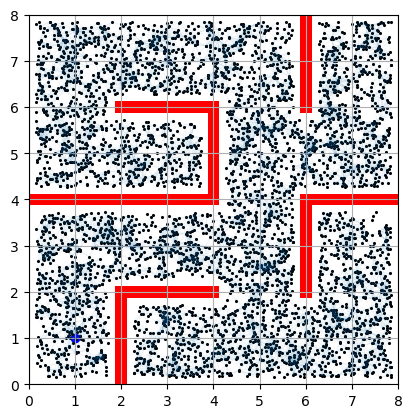

In [ ]:
fig, ax = plt.subplots()
ax.set_xlim(liminf_X, limsup_X)
ax.set_ylim(liminf_Y, limsup_Y)
ax.set_aspect('equal')

lc = mc.LineCollection(Edges, linewidths=0.01)
ax.add_collection(lc)

for i in range(len(obstacles)):
  ax.add_patch(Rectangle(obstacles[i].pos, obstacles[i].width, obstacles[i].height,
             facecolor = 'red',
             fill=True))

for v in Vertices:
  if v == rootVertex:
    plt.scatter(v.x, v.y, color = 'blue')
    #ax.add_patch(Circle((v.x, v.y), radius, facecolor='black', alpha = 0.25))
  else:
    plt.scatter(v.x, v.y, color = 'black', s=1.5)
    #ax.add_patch(Circle((v.x, v.y), radius, facecolor='yellow', alpha = 0.25))

plt.grid()
plt.show()

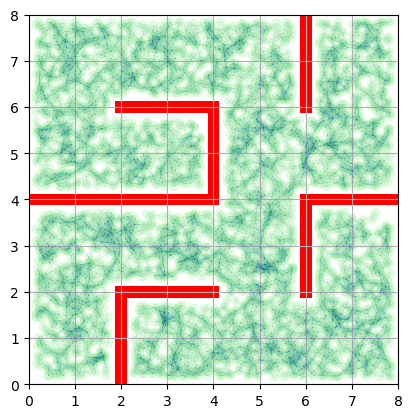

In [ ]:
fig, ax = plt.subplots()
ax.set_xlim(liminf_X, limsup_X)
ax.set_ylim(liminf_Y, limsup_Y)
ax.set_aspect('equal')

lc = mc.LineCollection(Edges, linewidths=0.01)
ax.add_collection(lc)

for i in range(len(obstacles)):
  ax.add_patch(Rectangle(obstacles[i].pos, obstacles[i].width, obstacles[i].height,
             facecolor = 'red',
             fill=True))

for v in Vertices:
  if v == rootVertex:
    #plt.scatter(v.x, v.y, color = 'blue')
    ax.add_patch(Circle((v.x, v.y), robot_r, facecolor='black', alpha = 0.25))
  else:
    #plt.scatter(v.x, v.y, color = 'black', s=1.5)
    ax.add_patch(Circle((v.x, v.y), robot_r, facecolor='lightgreen', alpha = 0.25))

plt.grid()
plt.show()

### Guardar listas obtenidas

In [ ]:
# Guardar las listas en un archivo

with open("vertices.pkl", "wb") as f:
    pickle.dump(Vertices, f)

with open("edges.pkl", "wb") as f:
    pickle.dump(Edges, f)

with open("neighbors.pkl", "wb") as f:
    pickle.dump(Neighbors, f)

In [23]:
# Cargar las listas desde el archivo

with open("vertices.pkl", "rb") as f:
    Vertices = pickle.load(f)

with open("edges.pkl", "rb") as f:
    Edges = pickle.load(f)

with open("neighbors.pkl", "rb") as f:
    Neighbors = pickle.load(f)

## Algoritmo de Dijkstra

In [24]:
def goalReached(v, goal, radius):
    if np.linalg.norm(np.array([v.x, v.y]) -  np.array([goal[0], goal[1]])) <= radius:
        return True
    else:
        return False

def distance(u, v):
    return np.linalg.norm(np.array([u.x, u.y]) - np.array([v.x, v.y]))

def Dijkstra(V, Neighbors, init, goal, goalradius):
    #Arreglo de distancias
    D = []
    #Inicializamos en infinito
    for v in V:
        D.append(np.inf)

    for i in range(len(V)):
        if V[i].x == init.x and V[i].y == init.y:
            init_id = i

    D[init_id] = 0

    #Arreglo para registrar los nodos visitados
    Visited = []
    for v in V:
        Visited.append(False)

    #Queue
    Q = set()
    for i in range(len(V)):
        Q.add(i)

    #Parents array
    Parents = []
    for i in range(len(V)):
        Parents.append(None)

    #Mientras la queue sea no vacia
    while(len(Q)):

        while(True):
            current_id = random.choice(tuple(Q))
            if V[current_id].activate == True:
                break
            else:
                Q.remove(current_id)

        #Seleccionamos el nodo con menor distancia
        for q in Q:
            if D[q] < D[current_id]:
                current_id = q

        #Marcamos el nodo como visitado
        Visited[current_id] = True

        if D[current_id] == np.infty:
            break

        if goalReached(V[current_id], goal, goalradius):
            break

        Q.remove(current_id)

        for n in Neighbors[current_id]:
            if V[n].activate == True:
                dist = D[current_id] + distance(V[current_id], V[n])
                if dist < D[n]:
                    D[n] = dist
                    Parents[n] = current_id

    if Parents[current_id] == None:
        return None, np.inf

    PathV = []
    PathE = []
    current_node = V[current_id]
    PathV.append(current_node)

    while current_node.x != init.x or current_node.y != init.y:
        parent_node = V[Parents[current_id]]
        parent_id = Parents[current_id]

        PathE.append(((parent_node.x, parent_node.y), (current_node.x, current_node.y)))

        current_node = parent_node
        current_id = parent_id
        PathV.append(current_node)

    PathV.reverse()

    return PathV, PathE

### Obtención de camino (sin obstáculo dinámico)

In [25]:
def getPath(V, Neighbors, init, goal, goalradius):
    initialPos = Nearest(V, init[0], init[1])
    initialVtx = vertex(initialPos[0], initialPos[1])

    optimalPathV, optimalPathE  = Dijkstra(V, Neighbors, initialVtx, goal, goalradius)

    if optimalPathV is None:
      print("No hay camino desde el punto de inicio al punto final.")

    return optimalPathV, optimalPathE

In [26]:
init_x = 7
init_y = 7

goal_x = 3
goal_y = 5
goal_r = 0.75

pathToGoalV, pathToGoalE = getPath(Vertices, Neighbors, [init_x, init_y], [goal_x, goal_y], goal_r)

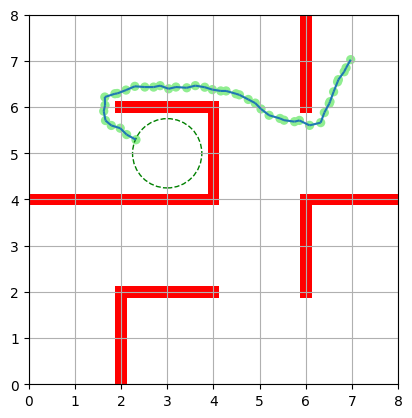

In [27]:
fig, ax = plt.subplots()
ax.set_xlim(liminf_X, limsup_X)
ax.set_ylim(liminf_Y, limsup_Y)
ax.set_aspect('equal')

lc = mc.LineCollection(pathToGoalE, linewidths=1.5)
ax.add_collection(lc)

for i in range(len(obstacles)):
  ax.add_patch(Rectangle(obstacles[i].pos, obstacles[i].width, obstacles[i].height,
             facecolor = 'red',
             fill=True))

for v in pathToGoalV:
  if v == rootVertex:
    #plt.scatter(v.x, v.y, color = 'blue')
    ax.add_patch(Circle((v.x, v.y), robot_r, facecolor='blue', alpha = 1.0))
  else:
    #plt.scatter(v.x, v.y, color = 'black', s=1.5)
    ax.add_patch(Circle((v.x, v.y), robot_r, facecolor='lightgreen', alpha = 1.0))

ax.add_patch(Circle((goal_x, goal_y), goal_r, edgecolor='green', ls = '--', fill = False))

plt.grid()
plt.show()

### Obtención de camino (con obstáculo dinámico)

In [28]:
def getPathObst(V, Neighbors, init, obst, obstradius, goal, goalradius):
    initialPos = Nearest(V, init[0], init[1])
    initialVtx = vertex(initialPos[0], initialPos[1])

    nearObst = Near(V, obst[0], obst[1], 2*obstradius)

    for v in V:
       if v in nearObst:
          v.activate = False

    optimalPathV, optimalPathE  = Dijkstra(V, Neighbors, initialVtx, goal, goalradius)

    #if optimalPathV is None:
      #print("No hay camino desde el punto de inicio al punto final.")

    for v in V:
       v.activate = True

    return optimalPathV, optimalPathE

In [29]:
init_x = 7
init_y = 7

goal_x = 3
goal_y = 5
goal_r = 0.75

obst_x = 7
obst_y = 6

pathToGoalV, pathToGoalE = getPathObst(Vertices, Neighbors, [init_x, init_y], [obst_x, obst_y], obst_reach, [goal_x, goal_y], goal_r)

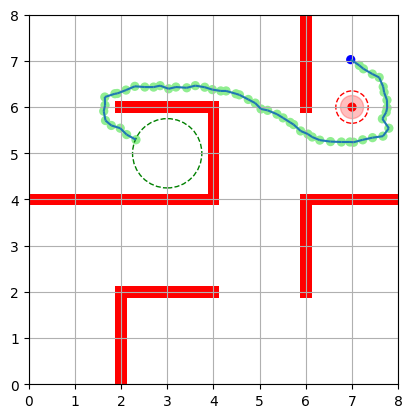

In [30]:
fig, ax = plt.subplots()
ax.set_xlim(liminf_X, limsup_X)
ax.set_ylim(liminf_Y, limsup_Y)
ax.set_aspect('equal')

lc = mc.LineCollection(pathToGoalE, linewidths=1.5)
ax.add_collection(lc)

for i in range(len(obstacles)):
  ax.add_patch(Rectangle(obstacles[i].pos, obstacles[i].width, obstacles[i].height,
             facecolor = 'red',
             fill=True))

for v in pathToGoalV:
  if v == pathToGoalV[0]:
    #plt.scatter(v.x, v.y, color = 'blue')
    ax.add_patch(Circle((v.x, v.y), robot_r, facecolor='blue', alpha = 1.0))
  else:
    #plt.scatter(v.x, v.y, color = 'black', s=1.5)
    ax.add_patch(Circle((v.x, v.y), robot_r, facecolor='lightgreen', alpha = 1.0))

ax.add_patch(Circle((goal_x, goal_y), goal_r, edgecolor='green', ls = '--', fill = False))
ax.add_patch(Circle((obst_x, obst_y), obstacle_r, facecolor='red'))
ax.add_patch(Circle((obst_x, obst_y), v_obst*d_t, edgecolor='red', facecolor='red', ls = '-', alpha = 0.25))
ax.add_patch(Circle((obst_x, obst_y), obst_reach, edgecolor='red', ls = '--', fill = False))

plt.grid()
plt.show()

# Recopilación de trayectorias para entrenamiento

### Creación de clases de utilidad
Con esto podremos identificar e iterar sobre las diferentes celdas del laberinto (en total son 16 cuadrados de 2x2 unidades)

In [8]:
class celda:
  infX = ''
  infY = ''
  supX = ''
  supY = ''

  def __init__(self, infx, supx, infy, supy):
    self.infX = infx
    self.infY = infy
    self.supX = supx
    self.supY = supy

In [9]:
#Declaramos las 16 celdas del laberinto
mazeCells = []

#(De abajo hacia arriba)#
#Primera fila
mazeCells.append(celda(0, 2, 0, 2))
mazeCells.append(celda(2, 4, 0, 2))
mazeCells.append(celda(4, 6, 0, 2))
mazeCells.append(celda(6, 8, 0, 2))

#Segunda fila
mazeCells.append(celda(0, 2, 2, 4))
mazeCells.append(celda(2, 4, 2, 4))
mazeCells.append(celda(4, 6, 2, 4))
mazeCells.append(celda(6, 8, 2, 4))

#Tercera fila
mazeCells.append(celda(0, 2, 4, 6))
mazeCells.append(celda(2, 4, 4, 6))
mazeCells.append(celda(4, 6, 4, 6))
mazeCells.append(celda(6, 8, 4, 6))

#Cuarta fila
mazeCells.append(celda(0, 2, 6, 8))
mazeCells.append(celda(2, 4, 6, 8))
mazeCells.append(celda(4, 6, 6, 8))
mazeCells.append(celda(6, 8, 6, 8))

### Parámetros para las trayectorias a considerar

In [ ]:
samplesPerCell = 10 #En el modelo completo, en teoria consideramos 10 posiciones INICIALES del robot para cada celda
obstSamplesPerCell = 15 #Posiciones del obstaculo dinamico por cada celda

### Posiciones iniciales del robot y del obstáculo dinámico

In [ ]:
initSamples = []

for c in mazeCells:
    i = 0
    while i < samplesPerCell:
        #Generamos punto aleatorio xrand
        xrand_x = np.random.uniform(c.infX, c.supX)
        xrand_y = np.random.uniform(c.infY, c.supY)

        #Verificamos que el punto aleatorio este libre de colisiones
        if sampleFree(xrand_x, xrand_y, connect_radius):
            initSamples.append(np.array([xrand_x, xrand_y]))
            i+=1

In [ ]:
obstSamples = []

for c in mazeCells:
    i = 0
    while i < obstSamplesPerCell:
        #Generamos punto aleatorio xrand
        xrand_x = np.random.uniform(c.infX, c.supX)
        xrand_y = np.random.uniform(c.infY, c.supY)

        #Verificamos que el punto aleatorio este libre de colisiones
        if sampleFree(xrand_x, xrand_y, connect_radius):
            obstSamples.append(np.array([xrand_x, xrand_y]))
            i+=1

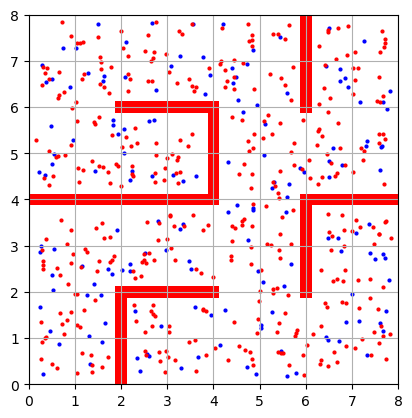

In [ ]:
fig, ax = plt.subplots()
ax.set_xlim(liminf_X, limsup_X)
ax.set_ylim(liminf_Y, limsup_Y)
ax.set_aspect('equal')

for i in range(len(obstacles)):
  ax.add_patch(Rectangle(obstacles[i].pos, obstacles[i].width, obstacles[i].height,
             facecolor = 'red',
             fill=True))

for s in initSamples:
    plt.scatter(s[0], s[1], color = 'blue', s=4.0)

for o in obstSamples:
    plt.scatter(o[0], o[1], color = 'red', s=4.0)

plt.grid()
plt.show()

In [38]:
obstSamplesPerCell = 30
obstSamples30 = []
minDist = 0.2

for c in mazeCells:
    i = 0
    while i < obstSamplesPerCell:
        #Generamos punto aleatorio xrand
        xrand_x = np.random.uniform(c.infX, c.supX)
        xrand_y = np.random.uniform(c.infY, c.supY)

        #Verificamos que el punto aleatorio este libre de colisiones
        if sampleFree(xrand_x, xrand_y, connect_radius) and checkMinDist([xrand_x, xrand_y], obstSamples30, minDist):
            obstSamples30.append(np.array([xrand_x, xrand_y]))
            i+=1

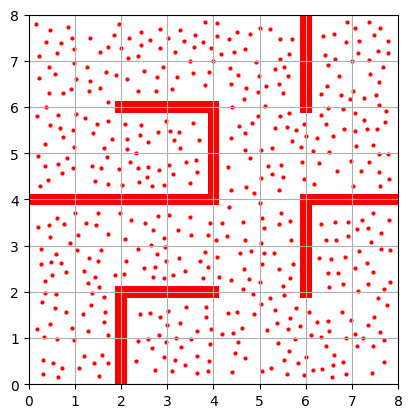

In [39]:
fig, ax = plt.subplots()
ax.set_xlim(liminf_X, limsup_X)
ax.set_ylim(liminf_Y, limsup_Y)
ax.set_aspect('equal')

for i in range(len(obstacles)):
  ax.add_patch(Rectangle(obstacles[i].pos, obstacles[i].width, obstacles[i].height,
             facecolor = 'red',
             fill=True))


for o in obstSamples30:
    plt.scatter(o[0], o[1], color = 'red', s=4.0)

plt.grid()
plt.show()

Guardamos las muestras de los puntos iniciales en archivo de texto

**IMPORTANTE: Ejecutar solo una vez los siguientes dos modulos, para evitar que los archivos de texto se sobreescriban y se pierdan**

In [ ]:
file = open("initialPoints.txt", "w")

for s in initSamples:
    file.write(str(s[0]))
    file.write(" ")
    file.write(str(s[1]))
    file.write("\n")

file.close()

In [ ]:
file = open("obstaclePoints.txt", "w")

for o in obstSamples:
    file.write(str(o[0]))
    file.write(" ")
    file.write(str(o[1]))
    file.write("\n")

file.close()

In [40]:
file = open("obstaclePoints30.txt", "w")

for o in obstSamples30:
    file.write(str(o[0]))
    file.write(" ")
    file.write(str(o[1]))
    file.write("\n")

file.close()

### Lectura de muestras iniciales y de obstáculo por archivos de texto existentes

In [ ]:
initialPoints = []

with open("initialPoints.txt", 'r') as file:
    for linea in file:
        x, y = map(float, linea.split())
        initialPoints.append(np.array([x, y]))

Modelo con 15 muestras de obstaculo dinamico por celda

In [ ]:
obstaclePoints = []

with open("obstaclePoints.txt", 'r') as file:
    for linea in file:
        x, y = map(float, linea.split())
        obstaclePoints.append(np.array([x, y]))

Modelo con 20 muestras de obstaculo dinamico por celda

In [12]:
obstaclePoints20 = []

with open("obstaclePoints20.txt", 'r') as file:
    for linea in file:
        x, y = map(float, linea.split())
        obstaclePoints20.append(np.array([x, y]))

Modelo con 25 muestras de obstaculo dinamico por celda

In [74]:
obstaclePoints25 = []

with open("obstaclePoints25.txt", 'r') as file:
    for linea in file:
        x, y = map(float, linea.split())
        obstaclePoints25.append(np.array([x, y]))

Modelo con 30 muestras de obstáculo dinámico por celda

In [41]:
obstaclePoints30 = []

with open("obstaclePoints30.txt", 'r') as file:
    for linea in file:
        x, y = map(float, linea.split())
        obstaclePoints30.append(np.array([x, y]))

### Clasificación de las muestras por celda (con el fin de poder iterar sobre cada celda)

In [ ]:
initialPointsCell = []

for i in range(16):
    pointsOfCell = []
    for j in range(samplesPerCell):
        pointsOfCell.append(initialPoints[samplesPerCell*i + j])

    initialPointsCell.append(pointsOfCell)
    i+=1

In [ ]:
obstPointsCell = []

for i in range(16):
    obstOfCell = []
    for j in range(obstSamplesPerCell):
        obstOfCell.append(obstaclePoints[obstSamplesPerCell*i + j])

    obstPointsCell.append(obstOfCell)
    i+=1

In [ ]:
obstPointsCell20 = []

for i in range(16):
    obstOfCell = []
    for j in range(20):
        obstOfCell.append(obstaclePoints20[20*i + j])

    obstPointsCell20.append(obstOfCell)
    i+=1

In [75]:
obstPointsCell25 = []

for i in range(16):
    obstOfCell = []
    for j in range(25):
        obstOfCell.append(obstaclePoints25[25*i + j])

    obstPointsCell25.append(obstOfCell)
    i+=1

In [42]:
obstPointsCell30 = []

for i in range(16):
    obstOfCell = []
    for j in range(30):
        obstOfCell.append(obstaclePoints30[30*i + j])

    obstPointsCell30.append(obstOfCell)
    i+=1

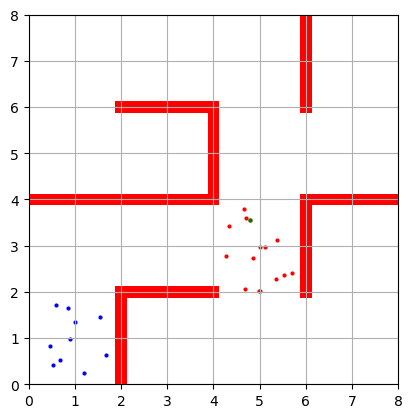

In [ ]:
fig, ax = plt.subplots()
ax.set_xlim(liminf_X, limsup_X)
ax.set_ylim(liminf_Y, limsup_Y)
ax.set_aspect('equal')

for i in range(len(obstacles)):
  ax.add_patch(Rectangle(obstacles[i].pos, obstacles[i].width, obstacles[i].height,
             facecolor = 'red',
             fill=True))


for p in initialPointsCell[0]:
    plt.scatter(p[0], p[1], color = 'blue', s=4.0)

for p in obstPointsCell[6]:
    plt.scatter(p[0], p[1], color = 'red', s=4.0)

plt.scatter(obstPointsCell[6][2][0], obstPointsCell[6][2][1], color = 'green', s=4.0)
plt.grid()
plt.show()

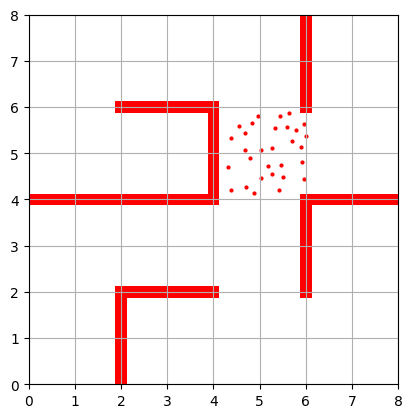

In [43]:
fig, ax = plt.subplots()
ax.set_xlim(liminf_X, limsup_X)
ax.set_ylim(liminf_Y, limsup_Y)
ax.set_aspect('equal')

for i in range(len(obstacles)):
  ax.add_patch(Rectangle(obstacles[i].pos, obstacles[i].width, obstacles[i].height,
             facecolor = 'red',
             fill=True))

for p in obstPointsCell30[10]:
    plt.scatter(p[0], p[1], color = 'red', s=4.0)

plt.grid()
plt.show()

## Prueba con 15 obstaculos dinamicos por celda y objetivo fijo

In [ ]:
obstSamplesPerCell = 15

15

Celda de obstaculo dinamico: 1
   Muestras procesadas:
   0   1   2   3   4   5   6   7   8   9   10   11   12   13   14
Celda de obstaculo dinamico: 2
   Muestras procesadas:
   0   1   2   3   4   5   6   7   8   9   10   11   12   13   14
Celda de obstaculo dinamico: 3
   Muestras procesadas:
   0   1   2   3   4   5   6   7   8   9   10   11   12   13   14
Celda de obstaculo dinamico: 4
   Muestras procesadas:
   0   1   2   3   4   5   6   7   8   9   10   11   12   13   14
Celda de obstaculo dinamico: 5
   Muestras procesadas:
   0   1   2   3   4   5   6   7   8   9   10   11   12   13   14
Celda de obstaculo dinamico: 6
   Muestras procesadas:
   0   1   2   3   4   5   6   7   8   9   10   11   12   13   14
Celda de obstaculo dinamico: 7
   Muestras procesadas:
   0   1   2   3   4   5   6   7   8   9   10   11   12   13   14
Celda de obstaculo dinamico: 8
   Muestras procesadas:
   0   1   2   3   4   5   6   7   8   9   10   11   12   13   14
Celda de obstaculo dinamico: 9
 

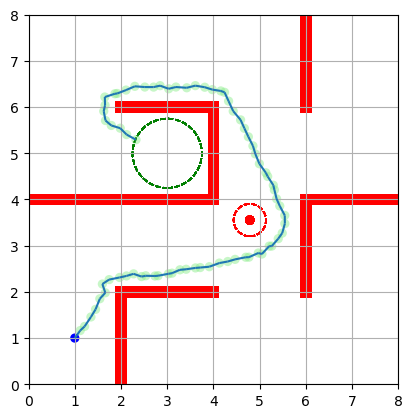

In [ ]:
trayectorias = []
initCell = 0
goalCell = 9
init = [1.0, 1.0]

file = open("trayectorias_15_obst.txt", "w")

fig, ax = plt.subplots()
ax.set_xlim(liminf_X, limsup_X)
ax.set_ylim(liminf_Y, limsup_Y)
ax.set_aspect('equal')

for i in range(len(obstacles)):
  ax.add_patch(Rectangle(obstacles[i].pos, obstacles[i].width, obstacles[i].height,
             facecolor = 'red',
             fill=True))


goalx = (mazeCells[goalCell].supX - mazeCells[goalCell].infX)/2 + mazeCells[goalCell].infX
goaly = (mazeCells[goalCell].supY - mazeCells[goalCell].infY)/2 + mazeCells[goalCell].infY
goalr = 0.75


for obstCell in range(16):

    if obstCell != initCell:
        print("Celda de obstaculo dinamico:", obstCell)
        print("   Muestras procesadas:")

        for obst_id in range(obstSamplesPerCell):
            print("  ", obst_id, end="")
            obstx = obstPointsCell[obstCell][obst_id][0]
            obsty = obstPointsCell[obstCell][obst_id][1]

            pathV, pathE = getPathObst(Vertices, Neighbors, [init[0], init[1]], [obstx, obsty], obst_reach, [goalx, goaly], goalr)

            if pathV != None:
                for v in pathV:
                    file.write(str(v.x))
                    file.write(" ")
                    file.write(str(v.y))
                    file.write(" ")

                file.write(str(goalx))
                file.write(" ")
                file.write(str(goaly))
                file.write(" ")
                file.write(str(obstx))
                file.write(" ")
                file.write(str(obsty))
                file.write("\n")

                if obstCell == 6 and obst_id == 2:
                    lc = mc.LineCollection(pathE, linewidths=1.5)
                    ax.add_collection(lc)

                    for v in pathV:
                        if v == pathV[0]:
                            #plt.scatter(v.x, v.y, color = 'blue')
                            ax.add_patch(Circle((v.x, v.y), robot_r, facecolor='blue', alpha = 1.0))
                        else:
                            #plt.scatter(v.x, v.y, color = 'black', s=1.5)
                            ax.add_patch(Circle((v.x, v.y), robot_r, facecolor='lightgreen', alpha = 0.5))

                        ax.add_patch(Circle((goalx, goaly), goalr, edgecolor='green', ls = '--', fill = False))
                        ax.add_patch(Circle((obstx, obsty), obstacle_r, facecolor='red'))
                        ax.add_patch(Circle((obstx, obsty), obst_reach, edgecolor='red', ls = '--', fill = False))


        print()

file.close()
plt.grid()
plt.show()

## Prueba con 20 obstaculos dinamicos por celda y objetivo fijo

In [ ]:
obstSamplesPerCell = 20

trayectorias = []
initCell = 0
goalCell = 9
init = [1.0, 1.0]

file = open("trayectorias_20_obst.txt", "w")

goalx = (mazeCells[goalCell].supX - mazeCells[goalCell].infX)/2 + mazeCells[goalCell].infX
goaly = (mazeCells[goalCell].supY - mazeCells[goalCell].infY)/2 + mazeCells[goalCell].infY
goalr = 0.75


for obstCell in range(16):

    if obstCell != initCell:
        print("Celda de obstaculo dinamico:", obstCell)
        print("   Muestras procesadas:")

        for obst_id in range(obstSamplesPerCell):
            print("  ", obst_id, end="")
            obstx = obstPointsCell20[obstCell][obst_id][0]
            obsty = obstPointsCell20[obstCell][obst_id][1]

            pathV, pathE = getPathObst(Vertices, Neighbors, [init[0], init[1]], [obstx, obsty], obst_reach, [goalx, goaly], goalr)

            if pathV != None:
                for v in pathV:
                    file.write(str(v.x))
                    file.write(" ")
                    file.write(str(v.y))
                    file.write(" ")

                file.write(str(goalx))
                file.write(" ")
                file.write(str(goaly))
                file.write(" ")
                file.write(str(obstx))
                file.write(" ")
                file.write(str(obsty))
                file.write("\n")

        print()

file.close()

Celda de obstaculo dinamico: 1
   Muestras procesadas:
   0   1   2   3   4   5   6   7   8   9   10   11   12   13   14   15   16   17   18   19
Celda de obstaculo dinamico: 2
   Muestras procesadas:
   0   1   2   3   4   5   6   7   8   9   10   11   12   13   14   15   16   17   18   19
Celda de obstaculo dinamico: 3
   Muestras procesadas:
   0   1   2   3   4   5   6   7   8   9   10   11   12   13   14   15   16   17   18   19
Celda de obstaculo dinamico: 4
   Muestras procesadas:
   0   1   2   3   4   5   6   7   8   9   10   11   12   13   14   15   16   17   18   19
Celda de obstaculo dinamico: 5
   Muestras procesadas:
   0   1   2   3   4   5   6   7   8   9   10   11   12   13   14   15   16   17   18   19
Celda de obstaculo dinamico: 6
   Muestras procesadas:
   0   1   2   3   4   5   6   7   8   9   10   11   12   13   14   15   16   17   18   19
Celda de obstaculo dinamico: 7
   Muestras procesadas:
   0   1   2   3   4   5   6   7   8   9   10   11   12   13   14   1

## Prueba con 25 obstaculos dinamicos por celda y objetivo fijo

In [ ]:
obstSamplesPerCell = 25

trayectorias = []
initCell = 0
goalCell = 9
init = [1.0, 1.0]

file = open("trayectorias_25_obst.txt", "w")

goalx = (mazeCells[goalCell].supX - mazeCells[goalCell].infX)/2 + mazeCells[goalCell].infX
goaly = (mazeCells[goalCell].supY - mazeCells[goalCell].infY)/2 + mazeCells[goalCell].infY
goalr = 0.75


for obstCell in range(16):

    if obstCell != initCell:
        print("Celda de obstaculo dinamico:", obstCell)
        print("   Muestras procesadas:")

        for obst_id in range(obstSamplesPerCell):
            print("  ", obst_id, end="")
            obstx = obstPointsCell25[obstCell][obst_id][0]
            obsty = obstPointsCell25[obstCell][obst_id][1]

            pathV, pathE = getPathObst(Vertices, Neighbors, [init[0], init[1]], [obstx, obsty], obst_reach, [goalx, goaly], goalr)

            if pathV != None:
                for v in pathV:
                    file.write(str(v.x))
                    file.write(" ")
                    file.write(str(v.y))
                    file.write(" ")

                file.write(str(goalx))
                file.write(" ")
                file.write(str(goaly))
                file.write(" ")
                file.write(str(obstx))
                file.write(" ")
                file.write(str(obsty))
                file.write("\n")

        print()

file.close()

Celda de obstaculo dinamico: 1
   Muestras procesadas:
   0   1   2   3   4   5   6   7   8   9   10   11   12   13   14   15   16   17   18   19   20   21   22   23   24
Celda de obstaculo dinamico: 2
   Muestras procesadas:
   0   1   2   3   4   5   6   7   8   9   10   11   12   13   14   15   16   17   18   19   20   21   22   23   24
Celda de obstaculo dinamico: 3
   Muestras procesadas:
   0   1   2   3   4   5   6   7   8   9   10   11   12   13   14   15   16   17   18   19   20   21   22   23   24
Celda de obstaculo dinamico: 4
   Muestras procesadas:
   0   1   2   3   4   5   6   7   8   9   10   11   12   13   14   15   16   17   18   19   20   21   22   23   24
Celda de obstaculo dinamico: 5
   Muestras procesadas:
   0   1   2   3   4   5   6   7   8   9   10   11   12   13   14   15   16   17   18   19   20   21   22   23   24
Celda de obstaculo dinamico: 6
   Muestras procesadas:
   0   1   2   3   4   5   6   7   8   9   10   11   12   13   14   15   16   17   18   19

## Prueba con 30 obstaculos dinamicos por celda y objetivo fijo

In [44]:
obstSamplesPerCell = 30

trayectorias = []
initCell = 0
goalCell = 9
init = [1.0, 1.0]

file = open("trayectorias_30_obst.txt", "w")

goalx = (mazeCells[goalCell].supX - mazeCells[goalCell].infX)/2 + mazeCells[goalCell].infX
goaly = (mazeCells[goalCell].supY - mazeCells[goalCell].infY)/2 + mazeCells[goalCell].infY
goalr = 0.75


for obstCell in range(16):

    if obstCell != initCell:
        print("Celda de obstaculo dinamico:", obstCell)
        print("   Muestras procesadas:")

        for obst_id in range(obstSamplesPerCell):
            print("  ", obst_id, end="")
            obstx = obstPointsCell30[obstCell][obst_id][0]
            obsty = obstPointsCell30[obstCell][obst_id][1]

            pathV, pathE = getPathObst(Vertices, Neighbors, [init[0], init[1]], [obstx, obsty], obst_reach, [goalx, goaly], goalr)

            if pathV != None:
                for v in pathV:
                    file.write(str(v.x))
                    file.write(" ")
                    file.write(str(v.y))
                    file.write(" ")

                file.write(str(goalx))
                file.write(" ")
                file.write(str(goaly))
                file.write(" ")
                file.write(str(obstx))
                file.write(" ")
                file.write(str(obsty))
                file.write("\n")

        print()

file.close()

Celda de obstaculo dinamico: 1
   Muestras procesadas:
   0   1   2   3   4   5   6   7   8   9   10   11   12   13   14   15   16   17   18   19   20   21   22   23   24   25   26   27   28   29
Celda de obstaculo dinamico: 2
   Muestras procesadas:
   0   1   2   3   4   5   6   7   8   9   10   11   12   13   14   15   16   17   18   19   20   21   22   23   24   25   26   27   28   29
Celda de obstaculo dinamico: 3
   Muestras procesadas:
   0   1   2   3   4   5   6   7   8   9   10   11   12   13   14   15   16   17   18   19   20   21   22   23   24   25   26   27   28   29
Celda de obstaculo dinamico: 4
   Muestras procesadas:
   0   1   2   3   4   5   6   7   8   9   10   11   12   13   14   15   16   17   18   19   20   21   22   23   24   25   26   27   28   29
Celda de obstaculo dinamico: 5
   Muestras procesadas:
   0   1   2   3   4   5   6   7   8   9   10   11   12   13   14   15   16   17   18   19   20   21   22   23   24   25   26   27   28   29
Celda de obstaculo d

# Entrenamiento

## Modelo con 15 muestras de obstaculo por celda

In [ ]:
data = []

with open('trayectorias_15_obst.txt', 'r') as file:
    lines = file.readlines()

# Procesa cada línea del archivo
for line in lines:
    # Separa los números en cada línea
    points = line.split()

    # Construimos las tuplas (q_t, q_goal) y q_{t+1}
    for i in range(0, len(points)-4, 2):
        q_t_q_obst_and_q_goal = [float(points[i]), float(points[i+1]), float(points[-2]), float(points[-1]), float(points[-4]), float(points[-3])]
        q_next = [float(points[i+2]), float(points[i+3])]
        data.append([q_t_q_obst_and_q_goal, q_next])

file.close()

In [ ]:
# Crea el dataframe
df = pd.DataFrame(data, columns=['(q_t, q_obst, q_goal)', 'q_{t+1}'])
df.head()

,"(q_t, q_obst, q_goal)",q_{t+1}
0,"[1.0, 1.0, 2.297172983589442, 1.70839039425736...","[1.1111316147043846, 1.221666228548032]"
1,"[1.1111316147043846, 1.221666228548032, 2.2971...","[1.2056500366835063, 1.413742938143197]"
2,"[1.2056500366835063, 1.413742938143197, 2.2971...","[1.1522359279520913, 1.5705714725384725]"
3,"[1.1522359279520913, 1.5705714725384725, 2.297...","[1.2552575279843605, 1.7779600659724748]"
4,"[1.2552575279843605, 1.7779600659724748, 2.297...","[1.3625580110850972, 1.9975241686403598]"


In [ ]:
df.shape

(14206, 2)

In [ ]:
X = df["(q_t, q_obst, q_goal)"].tolist()
Y = df["q_{t+1}"].tolist()

X = np.asarray(X)
Y = np.asarray(Y)

In [ ]:
mlp = models.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(64, activation="relu"),
  layers.Dense(32, activation="relu"),
  layers.Dense(2),
])

In [ ]:
model_name = 'mlp'
version = 'v1_15_obst'

models_path = 'C:/Users/israelb/Desktop/Proyecto 2024/Modelos/'
save_file_path = models_path+'trained_model_'+model_name+'_'+version+'_'+str(1000)+'_epochs.h5'


# Save the best model only wrt validation loss
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=save_file_path,
    monitor='val_loss',
    mode='min',
    save_best_only=True)


mlp.compile(loss=keras.losses.MeanSquaredError(),
			optimizer=keras.optimizers.Adam(learning_rate=0.001))

# Training
history = mlp.fit(x = X,
				    y = Y,
					batch_size = 128,
					epochs = 1000,
                    validation_split=0.05,
					verbose = 1,
                    callbacks=[model_checkpoint_callback]
                    )



Train on 13495 samples, validate on 711 samples
Epoch 1/1000
13495/13495 [==============================] - 2s 155us/step - loss: 1.0853 - val_loss: 0.0199
Epoch 2/1000
13495/13495 [==============================] - 1s 55us/step - loss: 0.0113 - val_loss: 0.0125
Epoch 3/1000
13495/13495 [==============================] - 1s 52us/step - loss: 0.0092 - val_loss: 0.0129
Epoch 4/1000
13495/13495 [==============================] - 1s 48us/step - loss: 0.0082 - val_loss: 0.0090
Epoch 5/1000
13495/13495 [==============================] - 1s 57us/step - loss: 0.0074 - val_loss: 0.0080
Epoch 6/1000
13495/13495 [==============================] - 1s 52us/step - loss: 0.0067 - val_loss: 0.0082
Epoch 7/1000
13495/13495 [==============================] - 1s 55us/step - loss: 0.0063 - val_loss: 0.0087
Epoch 8/1000
13495/13495 [==============================] - 1s 51us/step - loss: 0.0065 - val_loss: 0.0066
Epoch 9/1000
13495/13495 [==============================] - 1s 45us/step - loss: 0.0063 - val_l

In [ ]:
savepath = models_path+'trained_model_'+model_name+'_'+version+'_'+str(1000)+'_epochs.tf'
mlp.save(filepath=savepath)

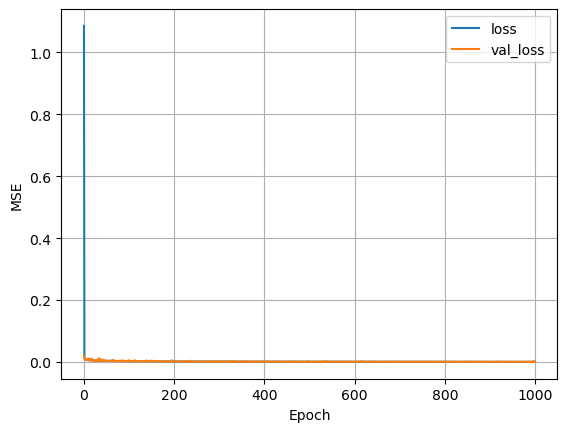

In [ ]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('MSE')
  plt.legend()
  plt.grid(True)


plot_loss(history)

In [ ]:
model_path = 'C:/Users/israelb/Desktop/Proyecto 2024/Modelos/trained_model_mlp_v1_15_obst_1000_epochs.h5'
mlp = keras.models.load_model(model_path)

In [ ]:
model_path = '/content/drive/My Drive/Proyecto 2024/Modelos/trained_model_mlp_v1_15_obst_1000_epochs.h5'
mlp = keras.models.load_model(model_path)

In [13]:
model_path = 'C:/Users/ramon/Documents/Universidad/Proyecto 2024/Modelos/trained_model_mlp_v1_15_obst_1000_epochs.h5'
mlp = keras.models.load_model(model_path)

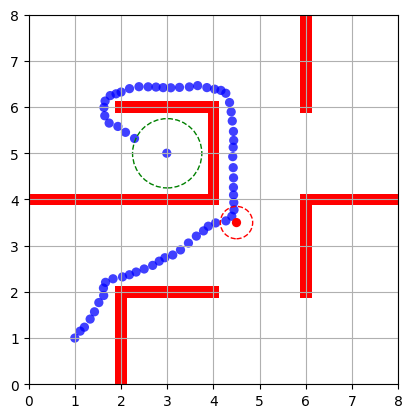

In [14]:
verticesPath = []

inicio = [1, 1]
goal = [3, 5]
obstaculo = [4.5, 3.5]

qt = [[inicio[0], inicio[1], obstaculo[0], obstaculo[1], goal[0], goal[1]]]
verticesPath.append([qt[0][0],qt[0][1]])

cnt = 0

while np.linalg.norm(np.array([qt[0][0],qt[0][1]]) - np.array(goal)) >= 0.75 and cnt <= 500:
    qnext = mlp.predict(qt, verbose=0)
    qt = [[qnext[0][0], qnext[0][1],  obstaculo[0], obstaculo[1], goal[0], goal[1]]]
    qt = np.asarray(qt)
    verticesPath.append([qnext[0][0],qnext[0][1]])
    cnt += 1


fig, ax = plt.subplots()
ax.set_xlim(liminf_X, limsup_X)
ax.set_ylim(liminf_Y, limsup_Y)
ax.set_aspect('equal')

for i in range(len(obstacles)):
  ax.add_patch(Rectangle(obstacles[i].pos, obstacles[i].width, obstacles[i].height,
             facecolor = 'red',
             fill=True))

for v in verticesPath:
    ax.add_patch(Circle((v[0], v[1]), robot_r, facecolor='blue', alpha = 0.75))

ax.add_patch(Circle((goal[0], goal[1]), 0.75, edgecolor='green', ls = '--', fill = False))
ax.add_patch(Circle((obstaculo[0], obstaculo[1]), obstacle_r, facecolor='red'))
ax.add_patch(Circle((obstaculo[0], obstaculo[1]), obst_reach, edgecolor='red', ls = '--', fill = False))

plt.grid()
plt.show()

## Modelo con 20 muestras de obstaculo por celda

In [1]:
data = []

with open('trayectorias_20_obst.txt', 'r') as file:
    lines = file.readlines()

# Procesa cada línea del archivo
for line in lines:
    # Separa los números en cada línea
    points = line.split()

    # Construimos las tuplas (q_t, q_goal) y q_{t+1}
    for i in range(0, len(points)-4, 2):
        q_t_q_obst_and_q_goal = [float(points[i]), float(points[i+1]), float(points[-2]), float(points[-1]), float(points[-4]), float(points[-3])]
        q_next = [float(points[i+2]), float(points[i+3])]
        data.append([q_t_q_obst_and_q_goal, q_next])

file.close()

In [4]:
# Crea el dataframe
df = pd.DataFrame(data, columns=['(q_t, q_obst, q_goal)', 'q_{t+1}'])
df.head()

,"(q_t, q_obst, q_goal)",q_{t+1}
0,"[1.0, 1.0, 3.791431097258431, 1.17931870236517...","[1.1164408338385519, 1.162660203367694]"
1,"[1.1164408338385519, 1.162660203367694, 3.7914...","[1.2126045603137046, 1.2526681804882598]"
2,"[1.2126045603137046, 1.2526681804882598, 3.791...","[1.349216862635087, 1.4569734418608196]"
3,"[1.349216862635087, 1.4569734418608196, 3.7914...","[1.4494980303984413, 1.6216811935998123]"
4,"[1.4494980303984413, 1.6216811935998123, 3.791...","[1.5416267325275754, 1.8510645851039822]"


In [5]:
df.shape

(18725, 2)

In [6]:
X = df["(q_t, q_obst, q_goal)"].tolist()
Y = df["q_{t+1}"].tolist()

X = np.asarray(X)
Y = np.asarray(Y)

In [9]:
mlp2 = models.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(64, activation="relu"),
  layers.Dense(32, activation="relu"),
  layers.Dense(2),
])

In [10]:
model_name = 'mlp'
version = 'v2_20_obst'

#models_path = 'C:/Users/israelb/Desktop/Proyecto 2024/Modelos/'
models_path = 'C:/Users/ramon/Documents/Universidad/Proyecto 2024/Modelos/'
save_file_path = models_path+'trained_model_'+model_name+'_'+version+'_'+str(1000)+'_epochs.h5'


# Save the best model only wrt validation loss
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=save_file_path,
    monitor='val_loss',
    mode='min',
    save_best_only=True)


mlp2.compile(loss=keras.losses.MeanSquaredError(),
			optimizer=keras.optimizers.Adam(learning_rate=0.001))

# Training
history = mlp2.fit(x = X,
				    y = Y,
					batch_size = 128,
					epochs = 1000,
                    validation_split=0.05,
					verbose = 1,
                    callbacks=[model_checkpoint_callback]
                    )



Train on 17788 samples, validate on 937 samples
Epoch 1/1000
17788/17788 [==============================] - 1s 30us/step - loss: 1.2175 - val_loss: 0.0239
Epoch 2/1000
17788/17788 [==============================] - 0s 21us/step - loss: 0.0116 - val_loss: 0.0187
Epoch 3/1000
17788/17788 [==============================] - 0s 20us/step - loss: 0.0094 - val_loss: 0.0133
Epoch 4/1000
17788/17788 [==============================] - 0s 17us/step - loss: 0.0084 - val_loss: 0.0120
Epoch 5/1000
17788/17788 [==============================] - 0s 19us/step - loss: 0.0077 - val_loss: 0.0096
Epoch 6/1000
17788/17788 [==============================] - 0s 18us/step - loss: 0.0075 - val_loss: 0.0086
Epoch 7/1000
17788/17788 [==============================] - 0s 18us/step - loss: 0.0070 - val_loss: 0.0078
Epoch 8/1000
17788/17788 [==============================] - 0s 17us/step - loss: 0.0067 - val_loss: 0.0070
Epoch 9/1000
17788/17788 [==============================] - 0s 17us/step - loss: 0.0063 - val_lo

In [11]:
savepath = models_path+'trained_model_'+model_name+'_'+version+'_'+str(1000)+'_epochs.tf'
mlp2.save(filepath=savepath)

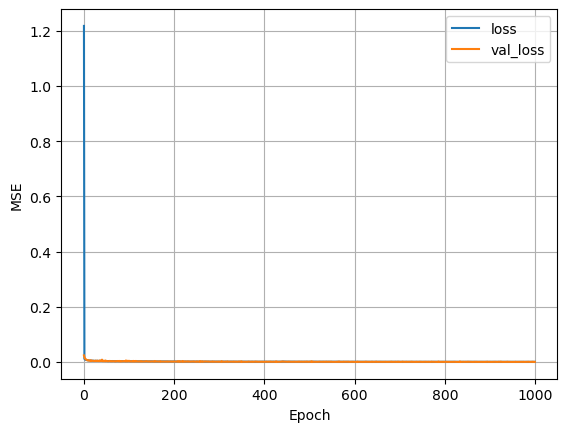

In [12]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('MSE')
  plt.legend()
  plt.grid(True)


plot_loss(history)

In [ ]:
model_path = '/content/drive/My Drive/Proyecto 2024/Modelos/trained_model_mlp_v1_20_obst_1000_epochs.tf'
mlp2 = keras.models.load_model(model_path)

In [10]:
model_path = 'C:/Users/ramon/Documents/Universidad/Proyecto 2024/Modelos/trained_model_mlp_v2_20_obst_1000_epochs.h5'
mlp2 = keras.models.load_model(model_path)

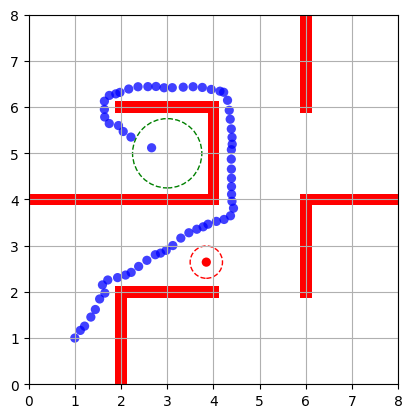

In [11]:
verticesPath = []

inicio = [1, 1]
goal = [3, 5]
#obstaculo = [4.5, 3.5]
obstaculo = [3.8466709809584483, 2.6438260029654916]

qt = [[inicio[0], inicio[1], obstaculo[0], obstaculo[1], goal[0], goal[1]]]
verticesPath.append([qt[0][0],qt[0][1]])

cnt = 0

while np.linalg.norm(np.array([qt[0][0],qt[0][1]]) - np.array(goal)) >= 0.75 and cnt <= 500:
    qnext = mlp2.predict(qt, verbose=0)
    qt = [[qnext[0][0], qnext[0][1],  obstaculo[0], obstaculo[1], goal[0], goal[1]]]
    qt = np.asarray(qt)
    verticesPath.append([qnext[0][0],qnext[0][1]])
    cnt += 1


fig, ax = plt.subplots()
ax.set_xlim(liminf_X, limsup_X)
ax.set_ylim(liminf_Y, limsup_Y)
ax.set_aspect('equal')

for i in range(len(obstacles)):
  ax.add_patch(Rectangle(obstacles[i].pos, obstacles[i].width, obstacles[i].height,
             facecolor = 'red',
             fill=True))

for v in verticesPath:
    ax.add_patch(Circle((v[0], v[1]), robot_r, facecolor='blue', alpha = 0.75))

ax.add_patch(Circle((goal[0], goal[1]), 0.75, edgecolor='green', ls = '--', fill = False))
ax.add_patch(Circle((obstaculo[0], obstaculo[1]), obstacle_r, facecolor='red'))
ax.add_patch(Circle((obstaculo[0], obstaculo[1]), obst_reach, edgecolor='red', ls = '--', fill = False))

plt.grid()
plt.show()

## Modelo con 25 muestras de obstaculo por celda

In [ ]:
data = []

with open('trayectorias_25_obst.txt', 'r') as file:
    lines = file.readlines()

# Procesa cada línea del archivo
for line in lines:
    # Separa los números en cada línea
    points = line.split()

    # Construimos las tuplas (q_t, q_goal) y q_{t+1}
    for i in range(0, len(points)-4, 2):
        q_t_q_obst_and_q_goal = [float(points[i]), float(points[i+1]), float(points[-2]), float(points[-1]), float(points[-4]), float(points[-3])]
        q_next = [float(points[i+2]), float(points[i+3])]
        data.append([q_t_q_obst_and_q_goal, q_next])

file.close()

# Crea el dataframe
df = pd.DataFrame(data, columns=['(q_t, q_obst, q_goal)', 'q_{t+1}'])
df.head()

,"(q_t, q_obst, q_goal)",q_{t+1}
0,"[1.0, 1.0, 2.6826671579842767, 1.5127983008119...","[1.1164408338385519, 1.162660203367694]"
1,"[1.1164408338385519, 1.162660203367694, 2.6826...","[1.2126045603137046, 1.2526681804882598]"
2,"[1.2126045603137046, 1.2526681804882598, 2.682...","[1.349216862635087, 1.4569734418608196]"
3,"[1.349216862635087, 1.4569734418608196, 2.6826...","[1.4494980303984413, 1.6216811935998123]"
4,"[1.4494980303984413, 1.6216811935998123, 2.682...","[1.5416267325275754, 1.8510645851039822]"


In [ ]:
df.shape

(23633, 2)

In [ ]:
X = df["(q_t, q_obst, q_goal)"].tolist()
Y = df["q_{t+1}"].tolist()

X = np.asarray(X)
Y = np.asarray(Y)

In [ ]:
mlp3 = models.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(64, activation="relu"),
  layers.Dense(32, activation="relu"),
  layers.Dense(2),
])

In [ ]:
model_name = 'mlp'
version = 'v1_25_obst'

models_path = 'C:/Users/israelb/Desktop/Proyecto 2024/Modelos/'
save_file_path = models_path+'trained_model_'+model_name+'_'+version+'_'+str(1000)+'_epochs.h5'


# Save the best model only wrt validation loss
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=save_file_path,
    monitor='val_loss',
    mode='min',
    save_best_only=True)


mlp3.compile(loss=keras.losses.MeanSquaredError(),
			optimizer=keras.optimizers.Adam(learning_rate=0.001))

# Training
history = mlp3.fit(x = X,
				    y = Y,
					batch_size = 128,
					epochs = 1000,
                    validation_split=0.05,
					verbose = 1,
                    callbacks=[model_checkpoint_callback]
                    )



Train on 22451 samples, validate on 1182 samples
Epoch 1/1000
22451/22451 [==============================] - 2s 67us/step - loss: 0.7577 - val_loss: 0.0145
Epoch 2/1000
22451/22451 [==============================] - 1s 54us/step - loss: 0.0093 - val_loss: 0.0081
Epoch 3/1000
22451/22451 [==============================] - 1s 51us/step - loss: 0.0071 - val_loss: 0.0061
Epoch 4/1000
22451/22451 [==============================] - 1s 48us/step - loss: 0.0062 - val_loss: 0.0053
Epoch 5/1000
22451/22451 [==============================] - 1s 52us/step - loss: 0.0057 - val_loss: 0.0052
Epoch 6/1000
22451/22451 [==============================] - 1s 53us/step - loss: 0.0053 - val_loss: 0.0051
Epoch 7/1000
22451/22451 [==============================] - 1s 45us/step - loss: 0.0051 - val_loss: 0.0047
Epoch 8/1000
22451/22451 [==============================] - 1s 51us/step - loss: 0.0053 - val_loss: 0.0049
Epoch 9/1000
22451/22451 [==============================] - 1s 47us/step - loss: 0.0051 - val_l

In [ ]:
savepath = models_path+'trained_model_'+model_name+'_'+version+'_'+str(1000)+'_epochs.tf'
mlp3.save(filepath=savepath)

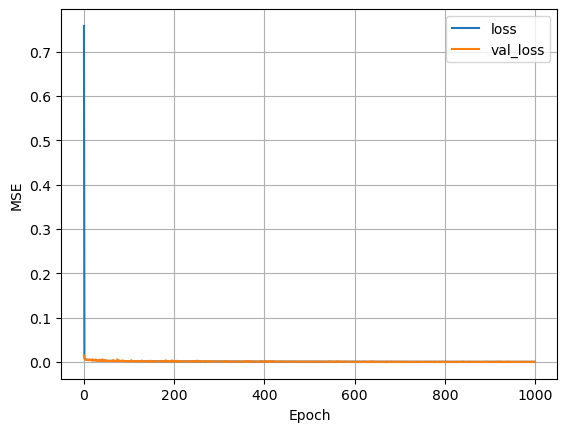

In [ ]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('MSE')
  plt.legend()
  plt.grid(True)


plot_loss(history)

In [ ]:
model_path = '/content/drive/My Drive/Proyecto 2024/Modelos/trained_model_mlp_v1_25_obst_1000_epochs.h5'
mlp3 = keras.models.load_model(model_path)

In [17]:
model_path = 'C:/Users/ramon/Documents/Universidad/Proyecto 2024/Modelos/trained_model_mlp_v1_25_obst_1000_epochs.h5'
mlp3 = keras.models.load_model(model_path)

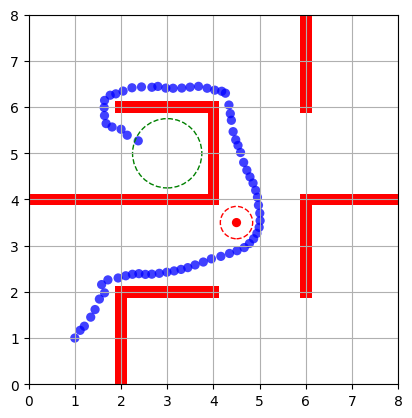

In [18]:
verticesPath = []

inicio = [1, 1]
goal = [3, 5]
obstaculo = [4.5, 3.5]
#obstaculo = [3.8466709809584483, 2.6438260029654916]

qt = [[inicio[0], inicio[1], obstaculo[0], obstaculo[1], goal[0], goal[1]]]
verticesPath.append([qt[0][0],qt[0][1]])

cnt = 0

while np.linalg.norm(np.array([qt[0][0],qt[0][1]]) - np.array(goal)) >= 0.75 and cnt <= 500:
    qnext = mlp3.predict(qt, verbose=0)
    qt = [[qnext[0][0], qnext[0][1],  obstaculo[0], obstaculo[1], goal[0], goal[1]]]
    qt = np.asarray(qt)
    verticesPath.append([qnext[0][0],qnext[0][1]])
    cnt += 1


fig, ax = plt.subplots()
ax.set_xlim(liminf_X, limsup_X)
ax.set_ylim(liminf_Y, limsup_Y)
ax.set_aspect('equal')

for i in range(len(obstacles)):
  ax.add_patch(Rectangle(obstacles[i].pos, obstacles[i].width, obstacles[i].height,
             facecolor = 'red',
             fill=True))

for v in verticesPath:
    ax.add_patch(Circle((v[0], v[1]), robot_r, facecolor='blue', alpha = 0.75))

ax.add_patch(Circle((goal[0], goal[1]), 0.75, edgecolor='green', ls = '--', fill = False))
ax.add_patch(Circle((obstaculo[0], obstaculo[1]), obstacle_r, facecolor='red'))
ax.add_patch(Circle((obstaculo[0], obstaculo[1]), obst_reach, edgecolor='red', ls = '--', fill = False))

plt.grid()
plt.show()

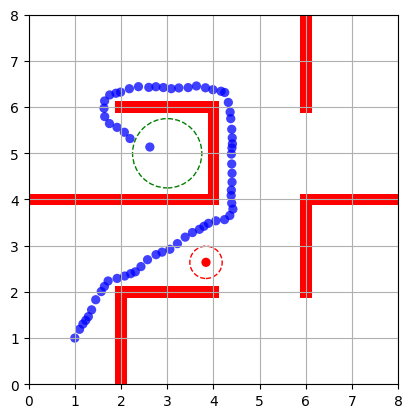

In [19]:
verticesPath = []

inicio = [1, 1]
goal = [3, 5]
#obstaculo = [4.5, 3.5]
obstaculo = [3.84, 2.64]

qt = [[inicio[0], inicio[1], obstaculo[0], obstaculo[1], goal[0], goal[1]]]
verticesPath.append([qt[0][0],qt[0][1]])

cnt = 0

while np.linalg.norm(np.array([qt[0][0],qt[0][1]]) - np.array(goal)) >= 0.75 and cnt <= 500:
    qnext = mlp3.predict(qt, verbose=0)
    qt = [[qnext[0][0], qnext[0][1],  obstaculo[0], obstaculo[1], goal[0], goal[1]]]
    qt = np.asarray(qt)
    verticesPath.append([qnext[0][0],qnext[0][1]])
    cnt += 1


fig, ax = plt.subplots()
ax.set_xlim(liminf_X, limsup_X)
ax.set_ylim(liminf_Y, limsup_Y)
ax.set_aspect('equal')

for i in range(len(obstacles)):
  ax.add_patch(Rectangle(obstacles[i].pos, obstacles[i].width, obstacles[i].height,
             facecolor = 'red',
             fill=True))

for v in verticesPath:
    ax.add_patch(Circle((v[0], v[1]), robot_r, facecolor='blue', alpha = 0.75))

ax.add_patch(Circle((goal[0], goal[1]), 0.75, edgecolor='green', ls = '--', fill = False))
ax.add_patch(Circle((obstaculo[0], obstaculo[1]), obstacle_r, facecolor='red'))
ax.add_patch(Circle((obstaculo[0], obstaculo[1]), obst_reach, edgecolor='red', ls = '--', fill = False))

plt.grid()
plt.show()

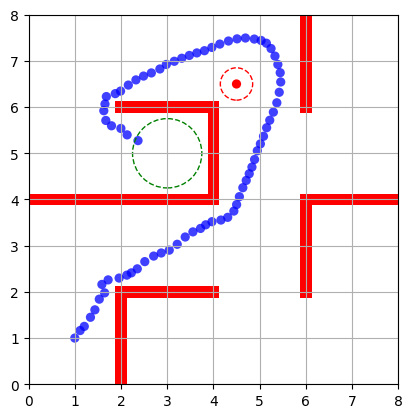

In [20]:
verticesPath = []

inicio = [1, 1]
goal = [3, 5]
#obstaculo = [4.5, 3.5]
obstaculo = [4.5, 6.5]

qt = [[inicio[0], inicio[1], obstaculo[0], obstaculo[1], goal[0], goal[1]]]
verticesPath.append([qt[0][0],qt[0][1]])

cnt = 0

while np.linalg.norm(np.array([qt[0][0],qt[0][1]]) - np.array(goal)) >= 0.75 and cnt <= 500:
    qnext = mlp3.predict(qt, verbose=0)
    qt = [[qnext[0][0], qnext[0][1],  obstaculo[0], obstaculo[1], goal[0], goal[1]]]
    qt = np.asarray(qt)
    verticesPath.append([qnext[0][0],qnext[0][1]])
    cnt += 1


fig, ax = plt.subplots()
ax.set_xlim(liminf_X, limsup_X)
ax.set_ylim(liminf_Y, limsup_Y)
ax.set_aspect('equal')

for i in range(len(obstacles)):
  ax.add_patch(Rectangle(obstacles[i].pos, obstacles[i].width, obstacles[i].height,
             facecolor = 'red',
             fill=True))

for v in verticesPath:
    ax.add_patch(Circle((v[0], v[1]), robot_r, facecolor='blue', alpha = 0.75))

ax.add_patch(Circle((goal[0], goal[1]), 0.75, edgecolor='green', ls = '--', fill = False))
ax.add_patch(Circle((obstaculo[0], obstaculo[1]), obstacle_r, facecolor='red'))
ax.add_patch(Circle((obstaculo[0], obstaculo[1]), obst_reach, edgecolor='red', ls = '--', fill = False))

plt.grid()
plt.show()

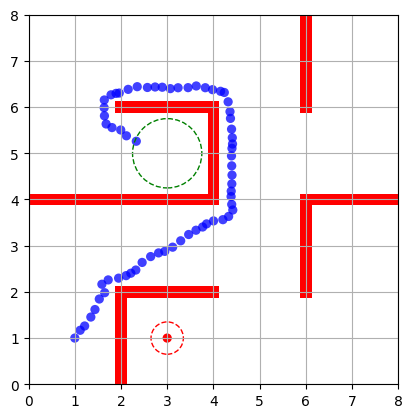

In [21]:
verticesPath = []

inicio = [1, 1]
goal = [3, 5]
#obstaculo = [4.5, 3.5]
obstaculo = [3, 1]

qt = [[inicio[0], inicio[1], obstaculo[0], obstaculo[1], goal[0], goal[1]]]
verticesPath.append([qt[0][0],qt[0][1]])

cnt = 0

while np.linalg.norm(np.array([qt[0][0],qt[0][1]]) - np.array(goal)) >= 0.75 and cnt <= 500:
    qnext = mlp3.predict(qt, verbose=0)
    qt = [[qnext[0][0], qnext[0][1],  obstaculo[0], obstaculo[1], goal[0], goal[1]]]
    qt = np.asarray(qt)
    verticesPath.append([qnext[0][0],qnext[0][1]])
    cnt += 1


fig, ax = plt.subplots()
ax.set_xlim(liminf_X, limsup_X)
ax.set_ylim(liminf_Y, limsup_Y)
ax.set_aspect('equal')

for i in range(len(obstacles)):
  ax.add_patch(Rectangle(obstacles[i].pos, obstacles[i].width, obstacles[i].height,
             facecolor = 'red',
             fill=True))

for v in verticesPath:
    ax.add_patch(Circle((v[0], v[1]), robot_r, facecolor='blue', alpha = 0.75))

ax.add_patch(Circle((goal[0], goal[1]), 0.75, edgecolor='green', ls = '--', fill = False))
ax.add_patch(Circle((obstaculo[0], obstaculo[1]), obstacle_r, facecolor='red'))
ax.add_patch(Circle((obstaculo[0], obstaculo[1]), obst_reach, edgecolor='red', ls = '--', fill = False))

plt.grid()
plt.show()

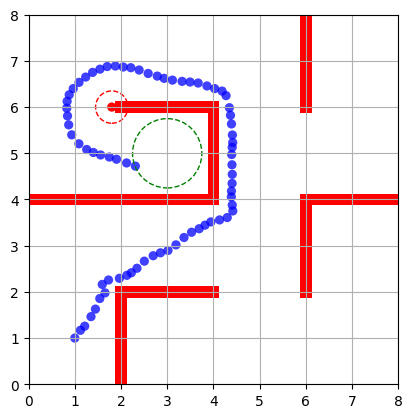

In [22]:
verticesPath = []

inicio = [1, 1]
goal = [3, 5]
#obstaculo = [4.5, 3.5]
obstaculo = [1.8, 6.0]

qt = [[inicio[0], inicio[1], obstaculo[0], obstaculo[1], goal[0], goal[1]]]
verticesPath.append([qt[0][0],qt[0][1]])

cnt = 0

while np.linalg.norm(np.array([qt[0][0],qt[0][1]]) - np.array(goal)) >= 0.75 and cnt <= 500:
    qnext = mlp3.predict(qt, verbose=0)
    qt = [[qnext[0][0], qnext[0][1],  obstaculo[0], obstaculo[1], goal[0], goal[1]]]
    qt = np.asarray(qt)
    verticesPath.append([qnext[0][0],qnext[0][1]])
    cnt += 1


fig, ax = plt.subplots()
ax.set_xlim(liminf_X, limsup_X)
ax.set_ylim(liminf_Y, limsup_Y)
ax.set_aspect('equal')

for i in range(len(obstacles)):
  ax.add_patch(Rectangle(obstacles[i].pos, obstacles[i].width, obstacles[i].height,
             facecolor = 'red',
             fill=True))

for v in verticesPath:
    ax.add_patch(Circle((v[0], v[1]), robot_r, facecolor='blue', alpha = 0.75))

ax.add_patch(Circle((goal[0], goal[1]), 0.75, edgecolor='green', ls = '--', fill = False))
ax.add_patch(Circle((obstaculo[0], obstaculo[1]), obstacle_r, facecolor='red'))
ax.add_patch(Circle((obstaculo[0], obstaculo[1]), obst_reach, edgecolor='red', ls = '--', fill = False))

plt.grid()
plt.show()

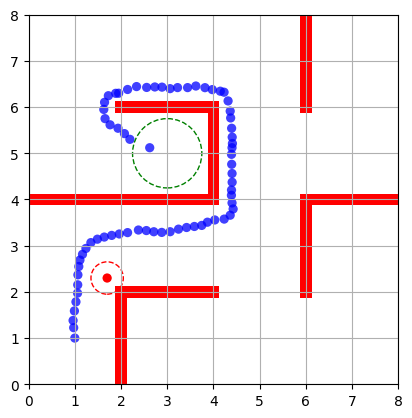

In [23]:
verticesPath = []

inicio = [1, 1]
goal = [3, 5]
#obstaculo = [4.5, 3.5]
obstaculo = [1.7, 2.3]

qt = [[inicio[0], inicio[1], obstaculo[0], obstaculo[1], goal[0], goal[1]]]
verticesPath.append([qt[0][0],qt[0][1]])

cnt = 0

while np.linalg.norm(np.array([qt[0][0],qt[0][1]]) - np.array(goal)) >= 0.75 and cnt <= 500:
    qnext = mlp3.predict(qt, verbose=0)
    qt = [[qnext[0][0], qnext[0][1],  obstaculo[0], obstaculo[1], goal[0], goal[1]]]
    qt = np.asarray(qt)
    verticesPath.append([qnext[0][0],qnext[0][1]])
    cnt += 1


fig, ax = plt.subplots()
ax.set_xlim(liminf_X, limsup_X)
ax.set_ylim(liminf_Y, limsup_Y)
ax.set_aspect('equal')

for i in range(len(obstacles)):
  ax.add_patch(Rectangle(obstacles[i].pos, obstacles[i].width, obstacles[i].height,
             facecolor = 'red',
             fill=True))

for v in verticesPath:
    ax.add_patch(Circle((v[0], v[1]), robot_r, facecolor='blue', alpha = 0.75))

ax.add_patch(Circle((goal[0], goal[1]), 0.75, edgecolor='green', ls = '--', fill = False))
ax.add_patch(Circle((obstaculo[0], obstaculo[1]), obstacle_r, facecolor='red'))
ax.add_patch(Circle((obstaculo[0], obstaculo[1]), obst_reach, edgecolor='red', ls = '--', fill = False))

plt.grid()
plt.show()

## Modelo con 30 muestras de obstaculo por celda

In [2]:
data = []

with open('trayectorias_30_obst.txt', 'r') as file:
    lines = file.readlines()

# Procesa cada línea del archivo
for line in lines:
    # Separa los números en cada línea
    points = line.split()

    # Construimos las tuplas (q_t, q_goal) y q_{t+1}
    for i in range(0, len(points)-4, 2):
        q_t_q_obst_and_q_goal = [float(points[i]), float(points[i+1]), float(points[-2]), float(points[-1]), float(points[-4]), float(points[-3])]
        q_next = [float(points[i+2]), float(points[i+3])]
        data.append([q_t_q_obst_and_q_goal, q_next])

file.close()

# Crea el dataframe
df = pd.DataFrame(data, columns=['(q_t, q_obst, q_goal)', 'q_{t+1}'])
df.head()

,"(q_t, q_obst, q_goal)",q_{t+1}
0,"[1.0, 1.0, 2.593784287206126, 0.98874278423477...","[1.1164408338385519, 1.162660203367694]"
1,"[1.1164408338385519, 1.162660203367694, 2.5937...","[1.2126045603137046, 1.2526681804882598]"
2,"[1.2126045603137046, 1.2526681804882598, 2.593...","[1.349216862635087, 1.4569734418608196]"
3,"[1.349216862635087, 1.4569734418608196, 2.5937...","[1.4494980303984413, 1.6216811935998123]"
4,"[1.4494980303984413, 1.6216811935998123, 2.593...","[1.5416267325275754, 1.8510645851039822]"


In [3]:
df.shape

(28062, 2)

In [4]:
X = df["(q_t, q_obst, q_goal)"].tolist()
Y = df["q_{t+1}"].tolist()

X = np.asarray(X)
Y = np.asarray(Y)

In [5]:
mlp4 = models.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(64, activation="relu"),
  layers.Dense(32, activation="relu"),
  layers.Dense(2),
])

In [6]:
model_name = 'mlp'
version = 'v1_30_obst'

#models_path = 'C:/Users/israelb/Desktop/Proyecto 2024/Modelos/'
models_path = 'C:/Users/ramon/Documents/Universidad/Proyecto 2024/Modelos/'
save_file_path = models_path+'trained_model_'+model_name+'_'+version+'_'+str(1000)+'_epochs.h5'


# Save the best model only wrt validation loss
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=save_file_path,
    monitor='val_loss',
    mode='min',
    save_best_only=True)


mlp4.compile(loss=keras.losses.MeanSquaredError(),
			optimizer=keras.optimizers.Adam(learning_rate=0.001))

# Training
history = mlp4.fit(x = X,
				    y = Y,
					batch_size = 128,
					epochs = 1000,
                    validation_split=0.05,
					verbose = 1,
                    callbacks=[model_checkpoint_callback]
                    )



Train on 26658 samples, validate on 1404 samples
Epoch 1/1000
26658/26658 [==============================] - 1s 38us/step - loss: 0.8450 - val_loss: 0.0126
Epoch 2/1000
26658/26658 [==============================] - 0s 17us/step - loss: 0.0086 - val_loss: 0.0085
Epoch 3/1000
26658/26658 [==============================] - 1s 19us/step - loss: 0.0072 - val_loss: 0.0075
Epoch 4/1000
26658/26658 [==============================] - 1s 23us/step - loss: 0.0059 - val_loss: 0.0054
Epoch 5/1000
26658/26658 [==============================] - 1s 24us/step - loss: 0.0054 - val_loss: 0.0054
Epoch 6/1000
26658/26658 [==============================] - 0s 17us/step - loss: 0.0050 - val_loss: 0.0044
Epoch 7/1000
26658/26658 [==============================] - 0s 17us/step - loss: 0.0049 - val_loss: 0.0043
Epoch 8/1000
26658/26658 [==============================] - 0s 17us/step - loss: 0.0048 - val_loss: 0.0093
Epoch 9/1000
26658/26658 [==============================] - 1s 21us/step - loss: 0.0046 - val_l

In [7]:
savepath = models_path+'trained_model_'+model_name+'_'+version+'_'+str(1000)+'_epochs.tf'
mlp4.save(filepath=savepath)

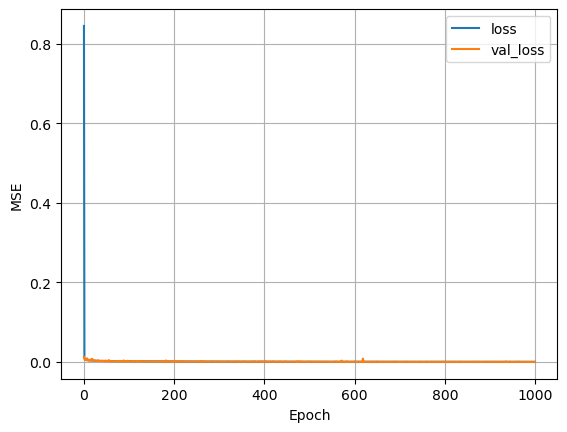

In [8]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('MSE')
  plt.legend()
  plt.grid(True)


plot_loss(history)

In [10]:
model_path = 'C:/Users/ramon/Documents/Universidad/Proyecto 2024/Modelos/trained_model_mlp_v1_30_obst_1000_epochs.h5'
mlp4 = keras.models.load_model(model_path)

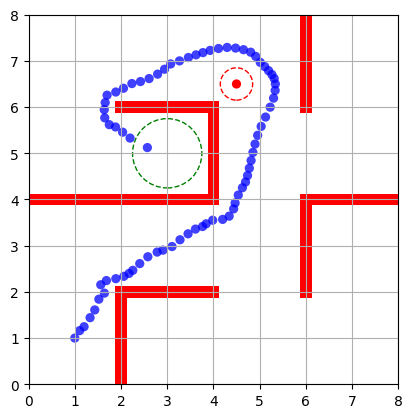

In [11]:
verticesPath = []

inicio = [1, 1]
goal = [3, 5]
#obstaculo = [4.5, 3.5]
obstaculo = [4.5, 6.5]

qt = [[inicio[0], inicio[1], obstaculo[0], obstaculo[1], goal[0], goal[1]]]
verticesPath.append([qt[0][0],qt[0][1]])

cnt = 0

while np.linalg.norm(np.array([qt[0][0],qt[0][1]]) - np.array(goal)) >= 0.75 and cnt <= 500:
    qnext = mlp4.predict(qt, verbose=0)
    qt = [[qnext[0][0], qnext[0][1],  obstaculo[0], obstaculo[1], goal[0], goal[1]]]
    qt = np.asarray(qt)
    verticesPath.append([qnext[0][0],qnext[0][1]])
    cnt += 1


fig, ax = plt.subplots()
ax.set_xlim(liminf_X, limsup_X)
ax.set_ylim(liminf_Y, limsup_Y)
ax.set_aspect('equal')

for i in range(len(obstacles)):
  ax.add_patch(Rectangle(obstacles[i].pos, obstacles[i].width, obstacles[i].height,
             facecolor = 'red',
             fill=True))

for v in verticesPath:
    ax.add_patch(Circle((v[0], v[1]), robot_r, facecolor='blue', alpha = 0.75))

ax.add_patch(Circle((goal[0], goal[1]), 0.75, edgecolor='green', ls = '--', fill = False))
ax.add_patch(Circle((obstaculo[0], obstaculo[1]), obstacle_r, facecolor='red'))
ax.add_patch(Circle((obstaculo[0], obstaculo[1]), obst_reach, edgecolor='red', ls = '--', fill = False))

plt.grid()
plt.show()

# Comparación de modelos

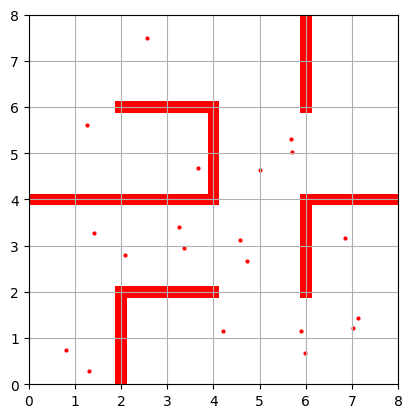

In [27]:
'''Creamos las muestras para validacion'''
v_obstSamples = []

i = 0
while i < 20:
  while True:
    #Generamos punto aleatorio
    v_obst_x = np.random.uniform(liminf_X, limsup_X)
    v_obst_y = np.random.uniform(liminf_Y, limsup_Y)

    #Verificamos que el punto aleatorio este libre de colisiones
    if sampleFree(v_obst_x, v_obst_y, connect_radius):
      v_obstSamples.append(np.array([v_obst_x, v_obst_y]))
      break
  i+=1

fig, ax = plt.subplots()
ax.set_xlim(liminf_X, limsup_X)
ax.set_ylim(liminf_Y, limsup_Y)
ax.set_aspect('equal')

for i in range(len(obstacles)):
  ax.add_patch(Rectangle(obstacles[i].pos, obstacles[i].width, obstacles[i].height,
             facecolor = 'red',
             fill=True))

for o in v_obstSamples:
    plt.scatter(o[0], o[1], color = 'red', s=4.0)

plt.grid()
plt.show()

In [28]:
file = open("v_obstaclePoints.txt", "w")

for o in v_obstSamples:
    file.write(str(o[0]))
    file.write(" ")
    file.write(str(o[1]))
    file.write("\n")

file.close()

In [12]:
v_obstaclePoints = []

with open("v_obstaclePoints.txt", 'r') as file:
    for linea in file:
        x, y = map(float, linea.split())
        v_obstaclePoints.append(np.array([x, y]))

### Modelo con 15 muestras de obstaculo

In [71]:
failed = 0

inicio = [1, 1]
goal = [3, 5]

for i in range(len(v_obstaclePoints)):
    f = False
    obstaculo = v_obstaclePoints[i]

    qt = [[inicio[0], inicio[1], obstaculo[0], obstaculo[1], goal[0], goal[1]]]

    cnt = 0

    while np.linalg.norm(np.array([qt[0][0],qt[0][1]]) - np.array(goal)) >= 0.75 and cnt <= 500:
        if sampleFree(qt[0][0], qt[0][1], robot_r) == False or np.linalg.norm(np.array([qt[0][0],qt[0][1]]) - np.array(obstaculo)) <= (obst_reach + robot_r):
            failed += 1
            f = True
            break

        qnext = mlp.predict(qt, verbose=0)
        qt = [[qnext[0][0], qnext[0][1],  obstaculo[0], obstaculo[1], goal[0], goal[1]]]
        qt = np.asarray(qt)  

        cnt += 1
    
    if f:
        print(i, ": Failed")
    else:
        print(i, ": Success")

print()
print("Para el modelo con 15 muestras de obstaculo dinamico por celda:")
print("    Pruebas totales: 20")
print("    Predicciones fallidas:", failed)

0 : Success
1 : Success
2 : Success
3 : Success
4 : Failed
5 : Failed
6 : Success
7 : Failed
8 : Success
9 : Success
10 : Success
11 : Success
12 : Failed
13 : Success
14 : Success
15 : Failed
16 : Success
17 : Success
18 : Success
19 : Success

Para el modelo con 15 muestras de obstaculo dinamico por celda:
    Pruebas totales: 20
    Predicciones fallidas: 5


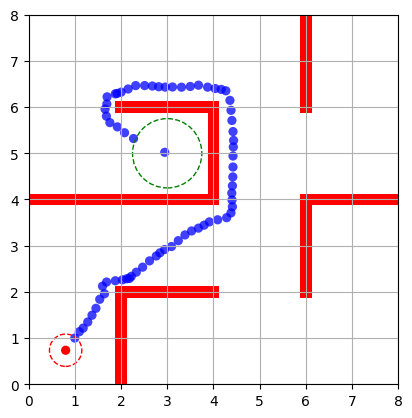

In [68]:
verticesPath = []

inicio = [1, 1]
goal = [3, 5]
#obstaculo = [4.5, 3.5]
obstaculo = v_obstaclePoints[7]

qt = [[inicio[0], inicio[1], obstaculo[0], obstaculo[1], goal[0], goal[1]]]
verticesPath.append([qt[0][0],qt[0][1]])

cnt = 0

while np.linalg.norm(np.array([qt[0][0],qt[0][1]]) - np.array(goal)) >= 0.75 and cnt <= 500:
    qnext = mlp.predict(qt, verbose=0)
    qt = [[qnext[0][0], qnext[0][1],  obstaculo[0], obstaculo[1], goal[0], goal[1]]]
    qt = np.asarray(qt)
    verticesPath.append([qnext[0][0],qnext[0][1]])
    cnt += 1


fig, ax = plt.subplots()
ax.set_xlim(liminf_X, limsup_X)
ax.set_ylim(liminf_Y, limsup_Y)
ax.set_aspect('equal')

for i in range(len(obstacles)):
  ax.add_patch(Rectangle(obstacles[i].pos, obstacles[i].width, obstacles[i].height,
             facecolor = 'red',
             fill=True))

for v in verticesPath:
    ax.add_patch(Circle((v[0], v[1]), robot_r, facecolor='blue', alpha = 0.75))

ax.add_patch(Circle((goal[0], goal[1]), 0.75, edgecolor='green', ls = '--', fill = False))
ax.add_patch(Circle((obstaculo[0], obstaculo[1]), obstacle_r, facecolor='red'))
ax.add_patch(Circle((obstaculo[0], obstaculo[1]), obst_reach, edgecolor='red', ls = '--', fill = False))

plt.grid()
plt.show()

### Modelo con 20 muestras de obstaculo

In [15]:
failed = 0

inicio = [1, 1]
goal = [3, 5]

for i in range(len(v_obstaclePoints)):
    f = False
    obstaculo = v_obstaclePoints[i]

    qt = [[inicio[0], inicio[1], obstaculo[0], obstaculo[1], goal[0], goal[1]]]

    cnt = 0

    while np.linalg.norm(np.array([qt[0][0],qt[0][1]]) - np.array(goal)) >= 0.75 and cnt <= 500:
        if sampleFree(qt[0][0], qt[0][1], robot_r) == False or np.linalg.norm(np.array([qt[0][0],qt[0][1]]) - np.array(obstaculo)) <= (obst_reach + robot_r):
            failed += 1
            f = True
            break

        qnext = mlp2.predict(qt, verbose=0)
        qt = [[qnext[0][0], qnext[0][1],  obstaculo[0], obstaculo[1], goal[0], goal[1]]]
        qt = np.asarray(qt)  

        cnt += 1
    
    if f:
        print(i, ": Failed")
    else:
        print(i, ": Success")

print()
print("Para el modelo con 20 muestras de obstaculo dinamico por celda:")
print("    Pruebas totales: 20")
print("    Predicciones fallidas:", failed)

0 : Success
1 : Success
2 : Failed
3 : Success
4 : Failed
5 : Success
6 : Success
7 : Failed
8 : Success
9 : Success
10 : Success
11 : Success
12 : Success
13 : Success
14 : Success
15 : Failed
16 : Success
17 : Success
18 : Success
19 : Success

Para el modelo con 20 muestras de obstaculo dinamico por celda:
    Pruebas totales: 20
    Predicciones fallidas: 4


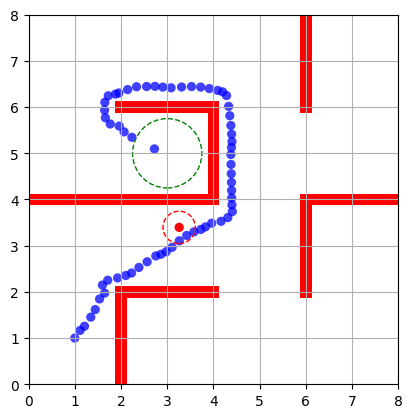

In [20]:
verticesPath = []

inicio = [1, 1]
goal = [3, 5]
#obstaculo = [4.5, 3.5]
obstaculo = v_obstaclePoints[15]

qt = [[inicio[0], inicio[1], obstaculo[0], obstaculo[1], goal[0], goal[1]]]
verticesPath.append([qt[0][0],qt[0][1]])

cnt = 0

while np.linalg.norm(np.array([qt[0][0],qt[0][1]]) - np.array(goal)) >= 0.75 and cnt <= 500:
    qnext = mlp2.predict(qt, verbose=0)
    qt = [[qnext[0][0], qnext[0][1],  obstaculo[0], obstaculo[1], goal[0], goal[1]]]
    qt = np.asarray(qt)
    verticesPath.append([qnext[0][0],qnext[0][1]])
    cnt += 1


fig, ax = plt.subplots()
ax.set_xlim(liminf_X, limsup_X)
ax.set_ylim(liminf_Y, limsup_Y)
ax.set_aspect('equal')

for i in range(len(obstacles)):
  ax.add_patch(Rectangle(obstacles[i].pos, obstacles[i].width, obstacles[i].height,
             facecolor = 'red',
             fill=True))

for v in verticesPath:
    ax.add_patch(Circle((v[0], v[1]), robot_r, facecolor='blue', alpha = 0.75))

ax.add_patch(Circle((goal[0], goal[1]), 0.75, edgecolor='green', ls = '--', fill = False))
ax.add_patch(Circle((obstaculo[0], obstaculo[1]), obstacle_r, facecolor='red'))
ax.add_patch(Circle((obstaculo[0], obstaculo[1]), obst_reach, edgecolor='red', ls = '--', fill = False))

plt.grid()
plt.show()

### Modelo con 25 muestras de obstaculo

In [72]:
failed = 0

inicio = [1, 1]
goal = [3, 5]

for i in range(len(v_obstaclePoints)):
    f = False
    obstaculo = v_obstaclePoints[i]

    qt = [[inicio[0], inicio[1], obstaculo[0], obstaculo[1], goal[0], goal[1]]]

    cnt = 0

    while np.linalg.norm(np.array([qt[0][0],qt[0][1]]) - np.array(goal)) >= 0.75 and cnt <= 500:
        if sampleFree(qt[0][0], qt[0][1], robot_r) == False or np.linalg.norm(np.array([qt[0][0],qt[0][1]]) - np.array(obstaculo)) <= (obst_reach + robot_r):
            failed += 1
            f = True
            break

        qnext = mlp3.predict(qt, verbose=0)
        qt = [[qnext[0][0], qnext[0][1],  obstaculo[0], obstaculo[1], goal[0], goal[1]]]
        qt = np.asarray(qt)

        cnt += 1
    
    if f:
        print(i, ": Failed")
    else:
        print(i, ": Success")

print()
print("Para el modelo con 25 muestras de obstaculo dinamico por celda:")
print("    Pruebas totales: 20")
print("    Predicciones fallidas:", failed)

0 : Success
1 : Success
2 : Success
3 : Success
4 : Failed
5 : Failed
6 : Success
7 : Failed
8 : Success
9 : Success
10 : Success
11 : Success
12 : Success
13 : Success
14 : Success
15 : Success
16 : Success
17 : Success
18 : Success
19 : Success

Para el modelo con 25 muestras de obstaculo dinamico por celda:
    Pruebas totales: 20
    Predicciones fallidas: 3


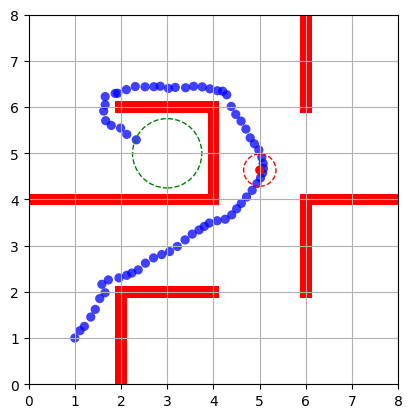

In [73]:
verticesPath = []

inicio = [1, 1]
goal = [3, 5]
#obstaculo = [4.5, 3.5]
obstaculo = v_obstaclePoints[5]

qt = [[inicio[0], inicio[1], obstaculo[0], obstaculo[1], goal[0], goal[1]]]
verticesPath.append([qt[0][0],qt[0][1]])

cnt = 0

while np.linalg.norm(np.array([qt[0][0],qt[0][1]]) - np.array(goal)) >= 0.75 and cnt <= 500:
    qnext = mlp3.predict(qt, verbose=0)
    qt = [[qnext[0][0], qnext[0][1],  obstaculo[0], obstaculo[1], goal[0], goal[1]]]
    qt = np.asarray(qt)
    verticesPath.append([qnext[0][0],qnext[0][1]])
    cnt += 1


fig, ax = plt.subplots()
ax.set_xlim(liminf_X, limsup_X)
ax.set_ylim(liminf_Y, limsup_Y)
ax.set_aspect('equal')

for i in range(len(obstacles)):
  ax.add_patch(Rectangle(obstacles[i].pos, obstacles[i].width, obstacles[i].height,
             facecolor = 'red',
             fill=True))

for v in verticesPath:
    ax.add_patch(Circle((v[0], v[1]), robot_r, facecolor='blue', alpha = 0.75))

ax.add_patch(Circle((goal[0], goal[1]), 0.75, edgecolor='green', ls = '--', fill = False))
ax.add_patch(Circle((obstaculo[0], obstaculo[1]), obstacle_r, facecolor='red'))
ax.add_patch(Circle((obstaculo[0], obstaculo[1]), obst_reach, edgecolor='red', ls = '--', fill = False))

plt.grid()
plt.show()

## Modelo con 30 muestras de obstáculo

In [13]:
failed = 0

inicio = [1, 1]
goal = [3, 5]

for i in range(len(v_obstaclePoints)):
    f = False
    obstaculo = v_obstaclePoints[i]

    qt = [[inicio[0], inicio[1], obstaculo[0], obstaculo[1], goal[0], goal[1]]]

    cnt = 0

    while np.linalg.norm(np.array([qt[0][0],qt[0][1]]) - np.array(goal)) >= 0.75 and cnt <= 500:
        if sampleFree(qt[0][0], qt[0][1], robot_r) == False or np.linalg.norm(np.array([qt[0][0],qt[0][1]]) - np.array(obstaculo)) <= (obst_reach + robot_r):
            failed += 1
            f = True
            break

        qnext = mlp4.predict(qt, verbose=0)
        qt = [[qnext[0][0], qnext[0][1],  obstaculo[0], obstaculo[1], goal[0], goal[1]]]
        qt = np.asarray(qt)  

        cnt += 1
    
    if f:
        print(i, ": Failed")
    else:
        print(i, ": Success")

print()
print("Para el modelo con 30 muestras de obstaculo dinamico por celda:")
print("    Pruebas totales: 20")
print("    Predicciones fallidas:", failed)

0 : Success
1 : Success
2 : Failed
3 : Success
4 : Failed
5 : Success
6 : Success
7 : Failed
8 : Success
9 : Success
10 : Success
11 : Success
12 : Failed
13 : Failed
14 : Success
15 : Success
16 : Success
17 : Failed
18 : Success
19 : Success

Para el modelo con 30 muestras de obstaculo dinamico por celda:
    Pruebas totales: 20
    Predicciones fallidas: 6


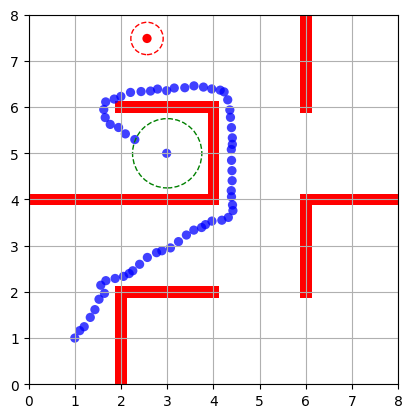

In [19]:
verticesPath = []

inicio = [1, 1]
goal = [3, 5]
#obstaculo = [4.5, 3.5]
obstaculo = v_obstaclePoints[17]

qt = [[inicio[0], inicio[1], obstaculo[0], obstaculo[1], goal[0], goal[1]]]
verticesPath.append([qt[0][0],qt[0][1]])

cnt = 0

while np.linalg.norm(np.array([qt[0][0],qt[0][1]]) - np.array(goal)) >= 0.75 and cnt <= 500:
    qnext = mlp4.predict(qt, verbose=0)
    qt = [[qnext[0][0], qnext[0][1],  obstaculo[0], obstaculo[1], goal[0], goal[1]]]
    qt = np.asarray(qt)
    verticesPath.append([qnext[0][0],qnext[0][1]])
    cnt += 1


fig, ax = plt.subplots()
ax.set_xlim(liminf_X, limsup_X)
ax.set_ylim(liminf_Y, limsup_Y)
ax.set_aspect('equal')

for i in range(len(obstacles)):
  ax.add_patch(Rectangle(obstacles[i].pos, obstacles[i].width, obstacles[i].height,
             facecolor = 'red',
             fill=True))

for v in verticesPath:
    ax.add_patch(Circle((v[0], v[1]), robot_r, facecolor='blue', alpha = 0.75))

ax.add_patch(Circle((goal[0], goal[1]), 0.75, edgecolor='green', ls = '--', fill = False))
ax.add_patch(Circle((obstaculo[0], obstaculo[1]), obstacle_r, facecolor='red'))
ax.add_patch(Circle((obstaculo[0], obstaculo[1]), obst_reach, edgecolor='red', ls = '--', fill = False))

plt.grid()
plt.show()